
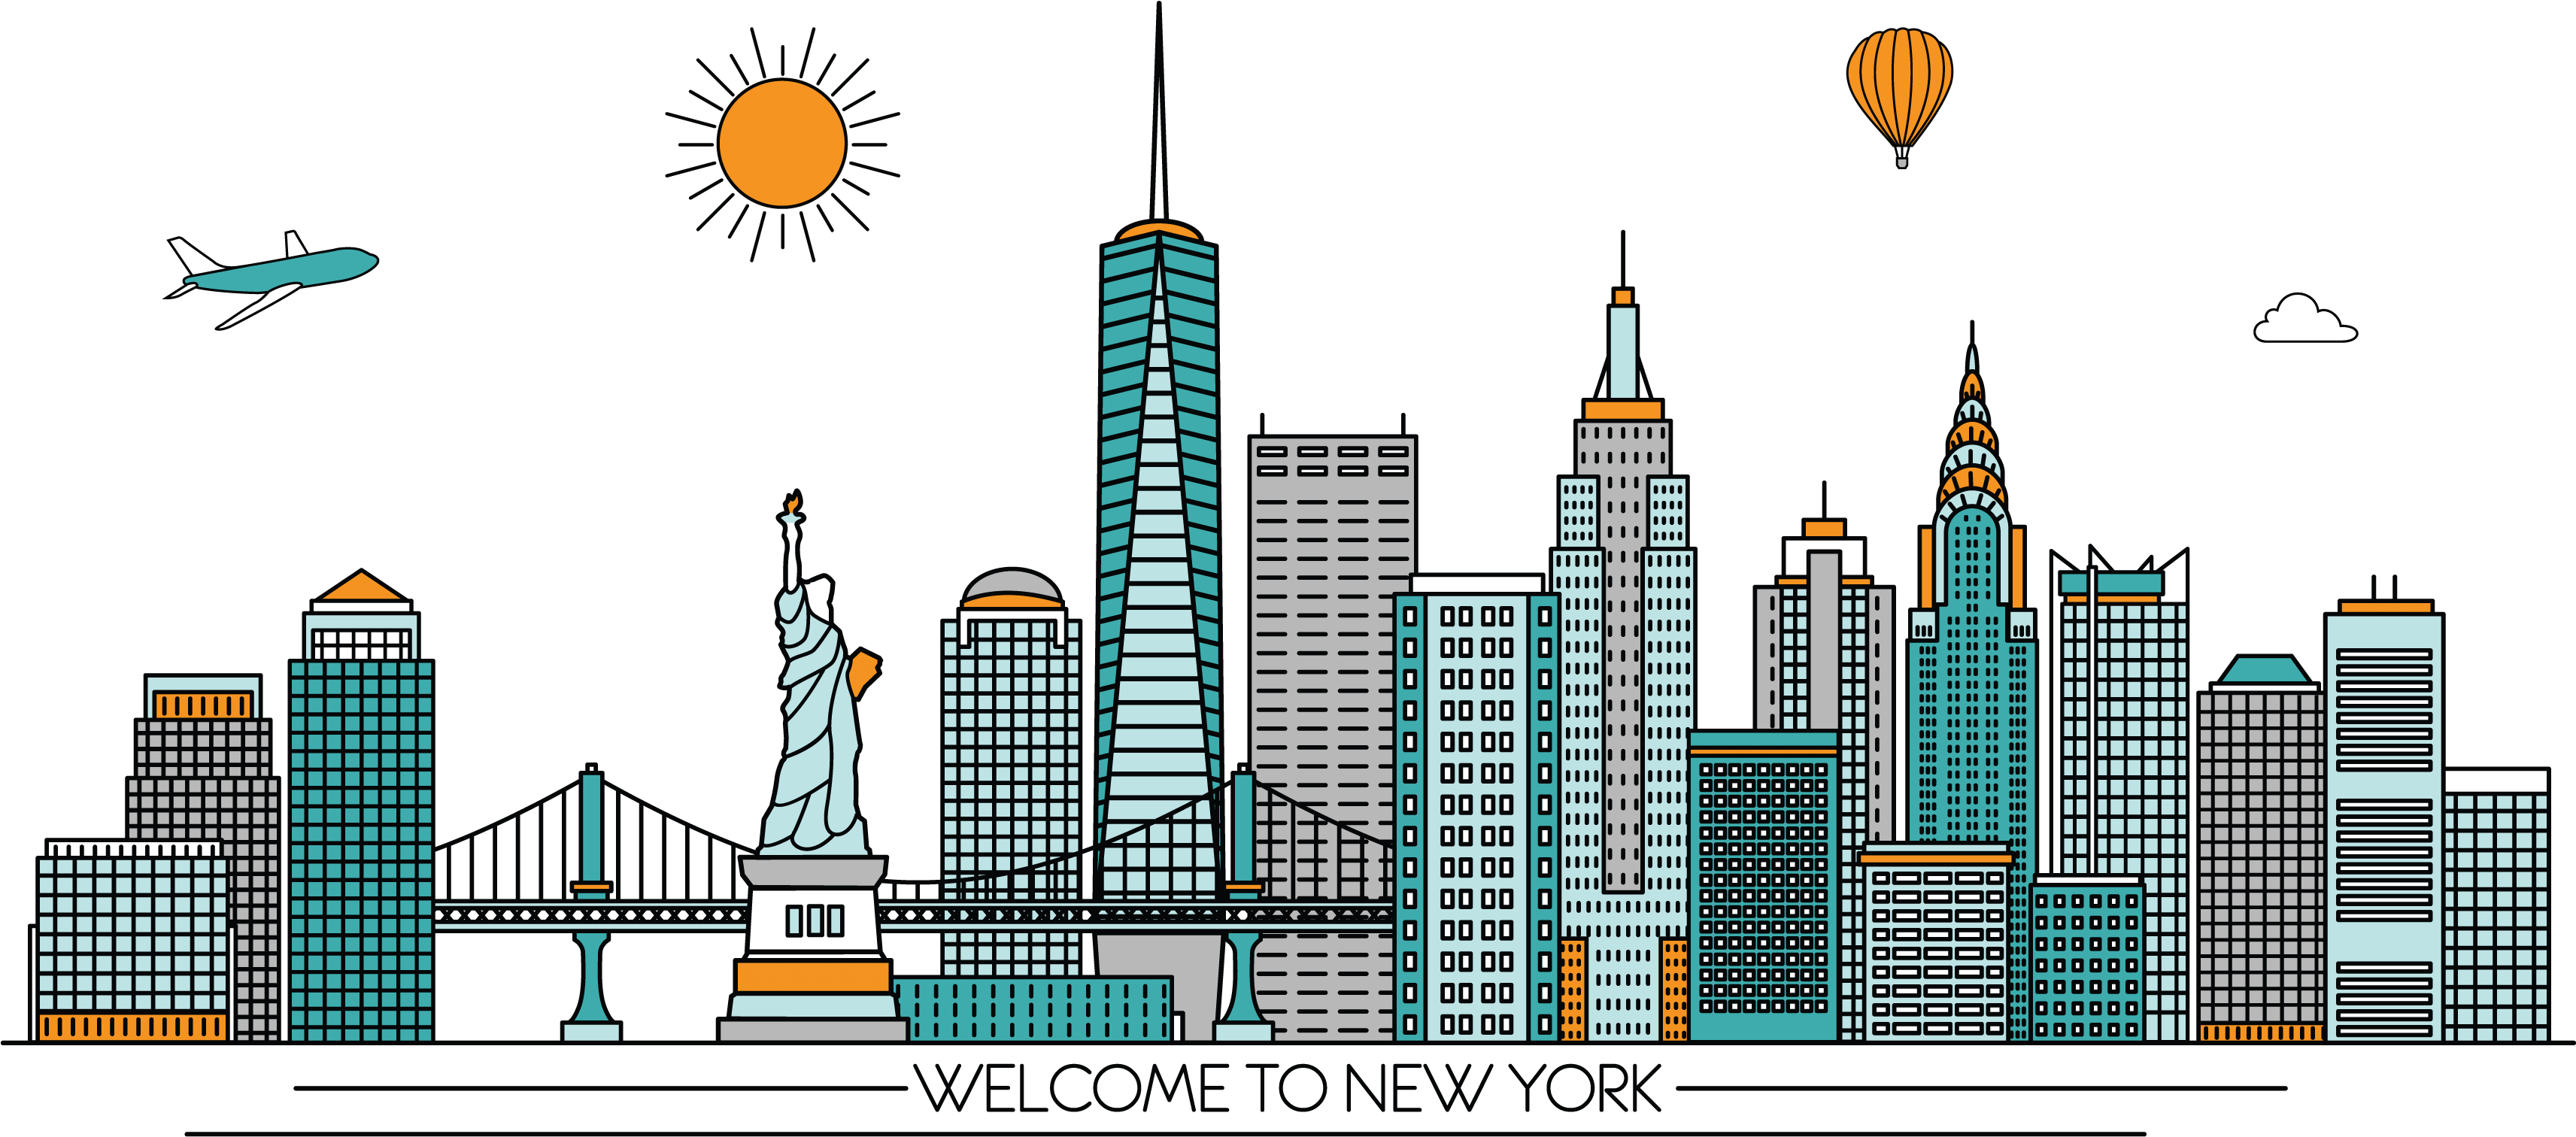

<h1><center>Project: Analyzing NYC High School Data</center></h1>


#### The goal
One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests and whether they're unfair to certain groups. Given our prior knowledge of this topic, investigating the correlations between `SAT` scores and demographics might be an interesting angle to take.

New York City boasts a substantial immigrant population and exhibits remarkable diversity. Therefore, evaluating demographic variables such as `race`, `income`, and `gender` in conjunction with `SAT` scores serves as a valuable method to assess the equity of the `SAT`. Specifically, if particular racial groups consistently demonstrate higher performance on the `SAT`, it could potentially indicate inequities within the test.

#### SAT score
The `SAT` is a standardized test widely used for college admissions in the United States. Since its debut in 1926, its name and scoring have changed several times. For much of its history, it was called the Scholastic Aptitude Test and had two components, Verbal and Mathematical, each of which was scored on a range from `200` to `800`. While this number has changed a few times, the dataset for our project is based on three sections and a total of `2,400` points (each section has 800 possible points).

Organizations often rank high schools by their average `SAT` scores. The scores are also considered a measure of overall school district quality.

#### The data
New York City makes its data on high school SAT scores available online, as well as the demographics for each high school. We will combine the following datasets into a single, clean pandas dataframe:

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4): SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt): Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3): Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e): Advanced Placement (AP) exam results for each high school
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a): The percentage of students who graduated and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j): Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8): Surveys of parents, teachers, and students at each school

#### Considerations

- Only high school students take the `SAT`, so we'll want to focus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contain dozens of schools.
- Our datasets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a `DBN` or district borough number.
- Aggregating data by district allows us to use the district mapping data to plot district-by-district differences.

*This project was completed as part of the Data Science Career Path offered by dataquest.io.*

#### Read in the data

All of these datasets are interrelated. We'll need to combine them into a single dataset before we can find correlations. To do so, we'll use the pandas library to read each file into a distinct dataframe, subsequently organizing all the dataframes within a dictionary.





In [40]:
# Import necessary packages
import pandas as pd
import numpy as np
import re

# Import necessary packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows= 75

# Parameters for visualization
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [2]:
# Create list with datasets to use
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

# Save all datasets into dictionary 'data'
for file in data_files:
    d = pd.read_csv("{0}".format(file))
    data[file.replace(".csv", "")] = d

# Check if all datasets are saved into the dictionary
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results'])

Our primary focus lies on the `SAT` dataset, denoted by the dictionary key `'sat_results'`. This dataset encompasses the SAT scores for each high school in New York City. Our objective is to establish correlations between specific information in this dataset and data from other relevant datasets. Lets get a brief overview about `'sat_results'`. 





In [3]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


The `'sat_results'` dataframe provides the following information:

- The DBN serves as a unique identifier for each school.
- Initial observations indicate that the dataset exclusively pertains to high schools.
- Each high school is represented by a singular row, ensuring the uniqueness of each DBN in the SAT data.
- We may eventually want to combine the three columns that contain SAT scores into a single column to make the scores easier to analyze.

Lets check the other datasets included inside the dictionary.

In [4]:
# Loop through data.keys and print first five rows of every dataaset
for key in data.keys():
    print(data[key].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

The dataframes provide the following information:

- Each dataset appears to either have a DBN column or the information we need to create one.
- Some fields look interesting for mapping
- We have to do some preprocessing, because some of the datasets appear to contain multiple rows for each school.

Prior to executing the merge, we need to read in the additional `survey` data and after that, do some data preprocessing.





#### Read in the surveys

In [5]:
# Read in the survey data, delimiter \t and specific encoding
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')

# Concat the two survey dataframes
survey = pd.concat([all_survey, d75_survey], axis=0)

survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The survey dataframe provide the following information:

- There are over 2000 columns, although the majority is unnecessary for our analysis. It is important to filter the data to exclude unnecessary columns to facilitate correlation analysis.
- The survey data incorporates a `'dbn'` column, necessitating a conversion to uppercase (`'DBN'`) for alignment with the name utilized in other datasets. This harmonization ensures consistency across the integrated data..

In [6]:
# Copy the data from the dbn column into a new column called DBN
survey["DBN"] = survey["dbn"].copy()

C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\281167393.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"].copy()


Now We must filter the columns to eliminate not needed elements. For this we can use the [data dictionary](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) and see which columns are relevant for the analysis.


In [7]:
# It looks like these are the relevant columns:

survey_columns = [
    "DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", 
    "saf_p_11", "com_p_11",  "eng_p_11", "aca_p_11", 
    "saf_t_11",  "com_t_11",  "eng_t_11", "aca_t_11", 
    "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11",
    "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11",]

# Filter survey so it only contains the columns we listed above.
survey = survey.loc[:,survey_columns]

# Assign the dataframe survey to the key survey
data["survey"] = survey

#### Add DBN columns

Upon exploring all the datasets, we noticed that `class_size` lack of a designated `DBN` column. However `hs_directory` contains a column labeled `dbn`, so we can just customize the column name. It is apparent that the `DBN` (District Borough Number) in the `sat_results` dataset is a composite of the `CSD` (Community School District) and `SCHOOL CODE` columns in the `class_size` dataset. The main distinction lies in the fact that the `DBN` is padded, ensuring that the `CSD` component consistently comprises two digits. Consequently, it is imperative to append a leading `0 `to the `CSD` if its length is less than two digits. 





In [8]:
# Renaming the dbn column to DBN
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Function to include a padded csd
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

# Use pad_csd function on CSD column of class_size column
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

# Create DBN column in class_size
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

We are on the verge of combining our datasets. Prior to this merger, we want to create an amalgamated column encapsulating the total `SAT` scores across distinct sections of the exam. This makes it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones.

To generate this column, we'll convert the columns `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` in the `sat_results` dataset to a numeric data type.





#### Convert columns to numeric

In [9]:
# This are the columns of interest
sat_cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

# Loop through the columns of sat_results and transform to numeric
for col in sat_cols:
    data["sat_results"][col] = pd.to_numeric(data["sat_results"][col], errors="coerce")

# create new column sat_score in sat_results dataframe
data['sat_results']['sat_score'] = data['sat_results'][sat_cols[0]] + data['sat_results'][sat_cols[1]] + data['sat_results'][sat_cols[2]]

# Check new column
data['sat_results']['sat_score'].head()

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

#### Parsing Geographic Coordinates for Schools

Subsequently, our objective is to extract and process the `latitude` and `longitude` coordinates corresponding to each school. This enables us to map the schools and uncover any geographic patterns in the data. Currently, the geographic coordinates are  within the text field denoted as `Location 1` in the `hs_directory` dataset.





In [10]:
# Functions to extract lon and lat values from hs_directory dataframe
def lat(string):
    coord = re.findall("\(.+, .+\)", string)
    lat = coord[0].split(",")[0].replace("(", "")
    return lat

def lon(string):
    coord = re.findall("\(.+, .+\)", string)
    lon = coord[0].split(",")[1].replace(")", "").strip()
    return lon

# Use function on hs_directory, location 1 column
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(lon)
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(lat)

# Convert new lon and lat column to numeric
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')

#### Condense datasets

The main dataset we want to analyze, `sat_results`, has unique `DBN` values for every high school in New York City. Other datasets, like `class_size` for example, aren't as clean. A single row in the `sat_results` dataset may match multiple rows in other datasets. This situation poses challenges as it introduces ambiguity regarding the determination of which entry in the `class_size` dataset should be amalgamated with the singular corresponding entry in `sat_results`. To resolve this issue, we'll condense the `class_size`, graduation and demographics datasets so that each `DBN` is unique.

##### Class_size

In [11]:
# Save class size dataframe to new variable
class_size = data["class_size"]

# Filter class_size for GRADE == 09-12 and PROGRAM TYPE == GEN ED
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size['DBN'].value_counts()

DBN
09X505    21
20K505    21
21K525    20
26Q435    20
25Q425    20
          ..
07X162     1
10X459     1
28Q217     1
22K078     1
10X118     1
Name: count, Length: 583, dtype: int64

Since `DBN` still isn't completely unique (as seen above), we can take the average across all of the classes a school offers. This gives us unique `DBN` values, while also incorporating as much data as possible into the average.

In [12]:
# Group class_size by DBN and calculate the mean
class_size = class_size.groupby("DBN").agg('mean', numeric_only=True)

# Reset the index to make DBN a column again
class_size.reset_index(inplace=True)

# Assign class_size back to the class_size key of the data dictionary.
data["class_size"] = class_size

##### Demographics

We only want to select rows where `schoolyear`` is `20112012. This will give us the most recent year of data, and also match our `SAT` results data.

In [13]:
# Filter for year
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

##### Graduation

We want to pick data from the most recent Cohort available, which is `2006`. We also want data from the full cohort, so we'll only pick rows where `Demographic` is `Total Cohort`.

In [14]:
# Filter data for Cohort == 2006 and Demographic === Total Cohort
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### Convert AP scores to numeric

The final task before merging the dataframes involves converting the `Advanced Placement` (AP) test scores from `string` to `numerical` values. 

High school students typically undertake AP exams as part of their college application process, with each exam corresponding to a specific school subject. Achieving high scores in these exams may grant students college credit.





In [15]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

#### Combine the datasets

Now we'll merge the specific dataframes. First, we'll assign data `sat_results` to the variable `combined`. Then, we'll `merge` the other dataframes with `combined`. When we're finished, `combined` has columns from all of the datasets.

In [16]:
# Create variable with dataframe sat_results
combined = data["sat_results"]

# Merge combined with dataframes ap_2010 and graduation on DBN with left join
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# Create list with dataframes to merge
merge_list = ["class_size", "demographics", "survey", "hs_directory"]

# Merge listed dataframes with combined, on DBN with inner join
for m in merge_list:
    combined = combined.merge(data[m], on="DBN", how="inner")

Due to the merging process, and especially due to `left` join, we generated `NaN` values. Lets fill these values with the column mean values

In [17]:
# Fill NaN with mean value by column
combined = combined.fillna(combined.mean(numeric_only=True))

# Fill every leftover NaN value with 0
combined = combined.fillna(0)

# Check first five rows of new combined dataframe
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lon,lat
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",-73.985260,40.713764
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",-73.984797,40.712332
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",-73.983041,40.729783
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",-73.985673,40.720569
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",-73.979426,40.718725


#### School district column for mapping
The data cleaning and combining process has been successfully completed, resulting in a refined dataset suitable for analysis. 

An intersting approach for examination involves mapping the statistics at the school district level. To facilitate this, the inclusion of a new column in the dataset specifying the `school district` proves instrumental.h this.


In [18]:
# Function to extract school district values
def get_first_two_chars(dbn):
    return dbn[0:2]

# Use function to create new column school_dist
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars).copy()

C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\1650224553.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined["school_dist"] = combined["DBN"].apply(get_first_two_chars).copy()


#### Correlations

Now we are going to calculate correlations. Correlations tell us how closely related two columns are. We'll be using the r value, also called `Pearson's correlation coefficient`, to measure how closely two sequences of numbers are correlated.


In [19]:
# Calculate correlations
correlations = combined.corr(numeric_only=True)

# Filter correlations just for sat_score
correlations = correlations["sat_score"]

# Show correlations
correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Let us summarize the findings derived from the calculated correlations with `sat_score`:

- As anticipated, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, `SAT Writing Avg. Score`, and `sat_score` exhibit robust positive correlations with `sat_score`.
- Substantial racial disparities in `SAT` scores are evident, as indicated by variables such as `white_per`, `asian_per`, `black_per`, and `hispanic_per`.
- Ratings of school safety by teachers (`saf_t_11`) and students (`saf_s_11`) demonstrate positive correlations with `sat_score`.
- Student ratings of school academic standards (`aca_s_11`) exhibit positive correlations with `SAT` scores. However, similar correlations are not observed for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).
- Both the percentage and count of female students (`female_per` and `female_num`) positively correlate with `SAT `scores, whereas their male counterparts (`male_per` and `male_num`) exhibit negative correlations. This suggests a gender-based disparity in `SAT` performance, indicating potential advantages for female students.
- The variable `total_enrollment` demonstrates a notably strong positive correlation with `sat_score`. The unexpected nature of this relationship is interesting, as one might presume that smaller schools, with more personalized attention, would yield higher scores. Contrary to this assumption, larger schools tend to outperform in `SAT` scores.
  - Several other enrollment-related indicators, such as `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`, display similar correlation patterns, emphasizing their role as proxies for enrollment.
- The percentage of students eligible for free or reduced school lunch, reflective of household income (`frl_percent`), exhibits a robust negative correlation with `SAT` scores.

#### Plotting Enrollment

Given the correlation observed with `total_enrollment`, we can try to construct a scatterplot `total_enrollment` against `sat_score`. Each data point within the scatterplot corresponds to a distinct high school, facilitating the identification of potential patterns or trends within the data.


C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\672239886.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('cividis')


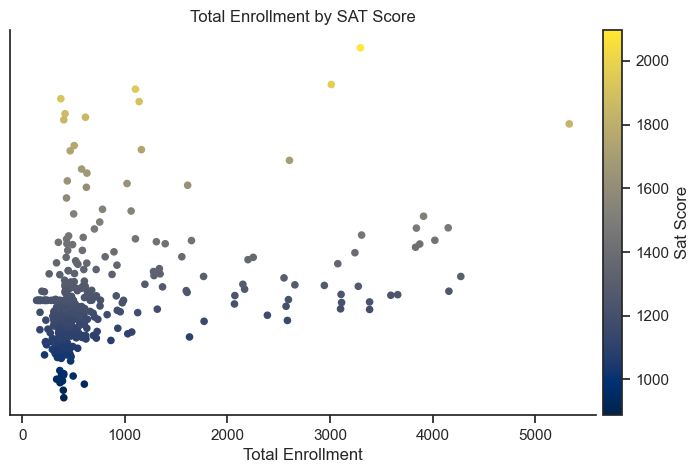

In [20]:
# Create a scatterplot with total_enrollment and sat_score

# Create figure and colormap
fig = plt.figure(figsize=(9,5))
cm = plt.cm.get_cmap('cividis')

# Create plot
ax = fig.add_subplot()
colorbar = ax.scatter(combined['total_enrollment'], combined['sat_score'], 
                       c=combined['sat_score'], vmin=combined['sat_score'].min(), 
                       vmax=combined['sat_score'].max(), s=20, cmap=cm)
plt.colorbar(colorbar, label='Sat Score', pad=.01)

# Remove y-axis
ax.yaxis.set_ticks([])   

# Label axis
plt.xlabel('Total Enrollment')
plt.title('Total Enrollment by SAT Score')
plt.show()

What did we observe?

Upon examination of the generated scatterplot, it seems that there is no strong correlation between `sat_score` and `total_enrollment`. In the absence of a strong correlation, the data points would ideally align. Contrarily, there's a large cluster of schools and then a few others going off in three different directions.

Nevertheless, an interesting cluster manifests in the bottom-left quadrant, characterized by low values for both `total_enrollment` and `sat_score`. This cluster may be what's making the r value so high. Identifying the schools within this cluster is warranted for further in-depth investigation.

#### Exploring Schools with Low SAT Scores and Enrollment

In [21]:
# Filter the dataframe for low enrollment and sat score values
low_enrollment = combined[combined['total_enrollment'] < 1000]
low_enrollment = combined[combined['sat_score'] < 1000]

# Check the Schools with low values for enrollment and sat score
low_enrollment['School Name'].value_counts()

School Name
0                                        2
INTERNATIONAL COMMUNITY HIGH SCHOOL      1
BRONX INTERNATIONAL HIGH SCHOOL          1
KINGSBRIDGE INTERNATIONAL HIGH SCHOOL    1
INTERNATIONAL SCHOOL FOR LIBERAL ARTS    1
HIGH SCHOOL OF WORLD CULTURES            1
BROOKLYN INTERNATIONAL HIGH SCHOOL       1
INTERNATIONAL HIGH SCHOOL AT PROSPECT    1
IT TAKES A VILLAGE ACADEMY               1
MULTICULTURAL HIGH SCHOOL                1
PAN AMERICAN INTERNATIONAL HIGH SCHOO    1
Name: count, dtype: int64

The school data presented in the preceding screen revealed, that the majority of high schools with low `total enrollment` and low `SAT` scores demonstrate a high percentages of English language learners. This suggests that it is, in fact, `ell_percent` that exhibits a robust correlation with `sat_score`, as opposed to `total_enrollment`. 

Therefore let us proceed to visualize the correlation between `ell_percent` and `sat_score`.`.

C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\2692699716.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('cividis')


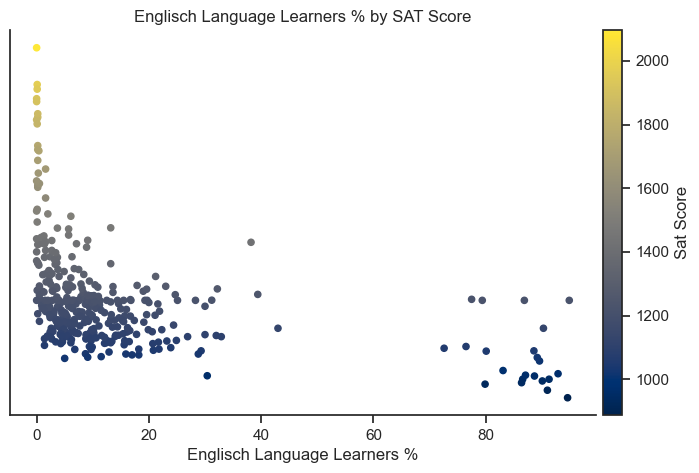

In [22]:
# Create a scatterplot with ell_percent and sat_score

# Create figure and colormap
fig = plt.figure(figsize=(9,5))
cm = plt.cm.get_cmap('cividis')

# Create plot
ax = fig.add_subplot()
colorbar = ax.scatter(combined['ell_percent'], combined['sat_score'], 
                       c=combined['sat_score'], vmin=combined['sat_score'].min(), 
                       vmax=combined['sat_score'].max(), s=20, cmap=cm)
plt.colorbar(colorbar, label='Sat Score', pad=.01)

# Remove y-axis
ax.yaxis.set_ticks([])   

# Label axis
plt.xlabel('Englisch Language Learners %')
plt.title('Englisch Language Learners % by SAT Score')
plt.show()

The r value for `ell_percent` and the graph above show, that `ell_percent` has a strong negative correlation with `sat_score`. In other words, if the percentage of `english language learners` increases, the `sat_score` decreases

#### Calculating District-Level Statistics
A sensible way of making complicated statistics easier to read is aggregation. We'll aggregate by `district`, which enables us to understand how `ell_percent` varies district-by-district instead of the unintelligibly granular school-by-school variation.

In [23]:
# Group dataframe by school district and calculate the mean values 
districts = combined.groupby('school_dist').agg('mean', numeric_only=True).reset_index()

# Save the mean sat score, mean ell_percent and school district 
ell_dist_sat = districts[['school_dist', 'sat_score', 'ell_percent']].sort_values(by='sat_score', ascending=False)
ell_dist_sat

,school_dist,sat_score,ell_percent
21,22,1450.500000,4.400000
30,31,1382.500000,2.860000
25,26,1377.600000,7.480000
24,25,1357.000000,19.737500
0,01,1354.500000,10.000000
27,28,1347.846947,4.963636
29,30,1326.382090,16.133333
1,02,1295.638184,13.006250
2,03,1293.443035,9.025000
4,05,1285.062687,4.157143


Based on the data above, we looked into the district for the top mean `sat_score` value, which is `district 22`. This district is related to Brooklyn and Brooklyn is considered a upper class area. additionally, the value for `ell_percent` in `district 22` is quite low with mean 4.4%. The lowest mean `sat_score` value is related to `district 12` which is The Bronx. The Bronx has the highest poverty rate in New York City. Here the mean for `ell_percent` is around 27%, which is the second highest value of all districts in our data.

#### Survey Correlations

In [24]:
# Save fields of the survey of parents, teachers, and students to survey_fields list
survey_fields = [ 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",]

# Slice survey dataframe for columns in survey_fields list
survey = survey[survey_fields]

# Create new dataframe in data dictionary with values from survey
data["survey"] = survey

# Check new dataframe survey
data["survey"].head()

,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,7.8,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,7.8,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,8.6,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,8.5,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,7.9,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


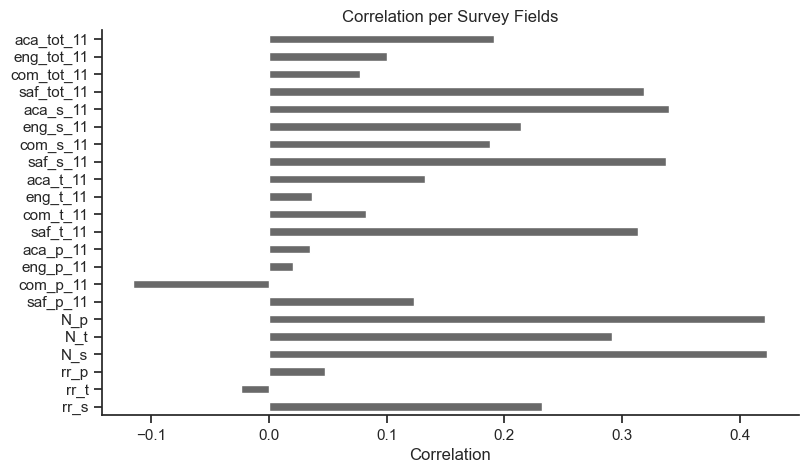

In [25]:
# Calculate correlations with sat_score for survey_fields and plot bar plot
plt.figure(figsize=(9,5))
combined.corr(numeric_only=True)['sat_score'][survey_fields].plot.barh(color='dimgrey')
plt.xlabel('Correlation')
plt.title('Correlation per Survey Fields')
plt.show()

- There exist notable correlations between `N_s`, `N_t`, `N_p`, and `sat_score`, and given their correlation with `total_enrollment`, it makes sense that they would be high.
- The correlations between the perceptions of safety by teachers and students (`saf_t_11` and `saf_s_11`) and `sat_score` are also noteworthy, aligning with the intuitive notion that an unsafe learning environment hinders both teaching and learning.
- Additionally, the correlation between `aca_s_11`, reflecting students' perceptions of academic standards, and `sat_score` is of interest. In contrast, this correlation is not mirrored in `aca_t_11` (how teachers perceive academic standards) or `aca_p_11` (how parents perceive academic standards).
- An interesting observation is the substantial correlation between `rr_s`, the proportion of students completing the survey, and `sat_score`. This may be attributed to the likelihood that academically successful students are more inclined to participate in survey activities.

#### Safety column

C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\2225253894.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('cividis')


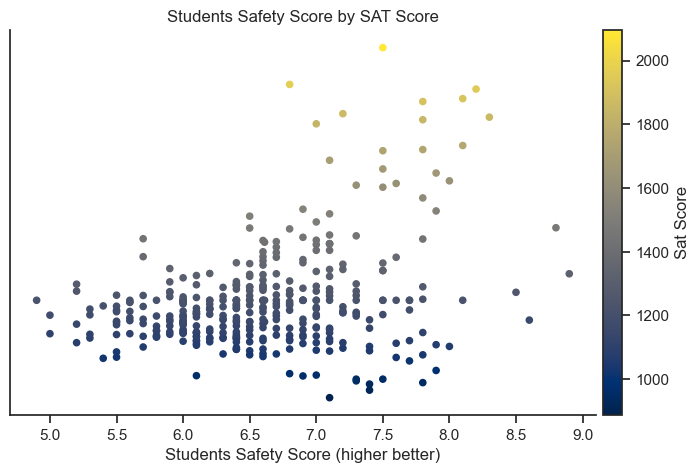

In [26]:
# Create a scatterplot for student safety score and sat_score

# Create figure and colormap
fig = plt.figure(figsize=(9,5))
cm = plt.cm.get_cmap('cividis')

# Create plot
ax = fig.add_subplot()
colorbar = ax.scatter(combined['saf_s_11'], combined['sat_score'], 
                       c=combined['sat_score'], vmin=combined['sat_score'].min(), 
                       vmax=combined['sat_score'].max(), s=20, cmap=cm)
plt.colorbar(colorbar, label='Sat Score', pad=.01)

# Remove y-axis
ax.yaxis.set_ticks([])  

plt.xlabel('Students Safety Score (higher better)')
plt.title('Students Safety Score by SAT Score')
plt.show()

Above we created a scatter plot with  `sat_score` and  `students_safety_score`. As you can see there is a weak pattern. When the `students_safety_score` increases, the `sat_score`also increases. In generel we could assume, that the `sat_score` is higher, if the place is considered as safe, compared to a less safer place. This is also the result of our correlation plot before. The correlation between `sat_score` and `saf_s_11` (students safety score) is about ~0.34, a weak-mid positiv correlation. 

It looks like there are a few schools with extremely high `SAT` scores and high safety scores. There are a few schools with low safety scores and low `SAT` scores. No school with a safety score lower than 6.5 has an average `SAT` score higher than 1500 or so.

#### Borough Safety

In [27]:
combined.groupby('boro').mean(numeric_only=True)['saf_s_11'].sort_values(ascending=False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

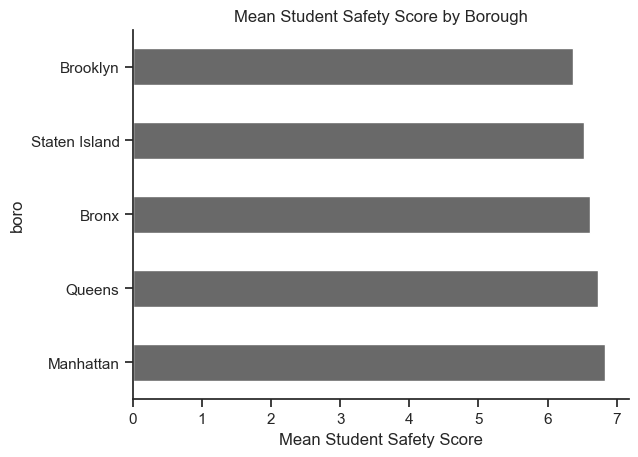

In [28]:
# Create a barh chart for the mean values of safety student by borough
combined.groupby('boro').mean(numeric_only=True)['saf_s_11'].sort_values(
    ascending=False).plot(kind='barh', color='dimgrey')

plt.title('Mean Student Safety Score by Borough')
plt.xlabel('Mean Student Safety Score')
plt.show()

Following the creation of a scatter plot depicting the relationship between safety scores and `SAT` scores, the dataset was subsequently grouped by boroughs. The mean safety scores for each borough were calculated and analyzed. The results indicate that `Manhattan` exhibits the highest mean safety score (6.83), while `Brooklyn` records the lowest mean safety score (6.37). Generally, safety scores across all New York boroughs fall within the range of 6 to 7. A discernible pattern emerges, with `Manhattan` and `Queens` consistently displaying higher safety scores, while `Brooklyn` tends to have lower safety scores.






#### Racial Differences

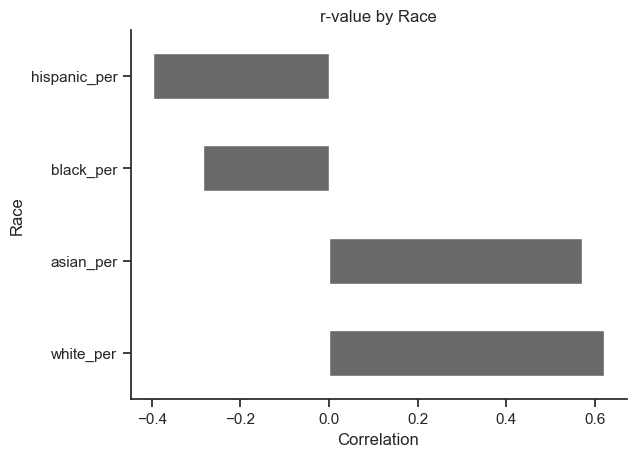

In [29]:
combined.corr(numeric_only=True)['sat_score'][['white_per', 'asian_per', 
                              'black_per', 'hispanic_per']].plot(kind='barh',
                                                                 color='dimgrey')
plt.title('r-value by Race')
plt.xlabel('Correlation')
plt.ylabel('Race')
plt.show()

The correlation bar chart generated provides insights into the relationship between demographic factors and `SAT` scores. Notably, the analysis reveals a negative correlation between the percentage of `Hispanic` or `Black` and `SAT` scores. In practical terms, if the percentage of `Hispanic` or `Black` is higher, the `SAT` scores tend to be lower. In contrast, if the percentage of `Asian` or `White` is higher, the `SAT` scores tend to be higher. 

This observed correlation may be attributed to disparities in funding for schools, particularly in areas with a higher percentage of `Black` or `Hispanic`students.

Now let's observe the `sat_score` for the percentage of `Hispanics` in a scatterplot.





C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\3975924533.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('cividis')


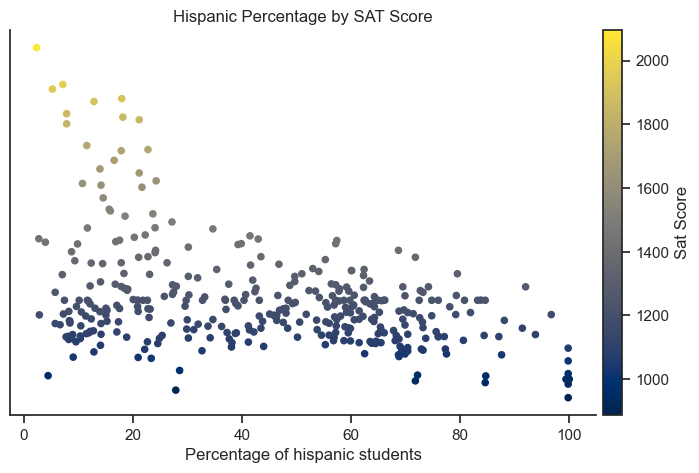

In [30]:
# Create a scatterplot for hispanic percentage score and sat_score

# Create figure and colormap
fig = plt.figure(figsize=(9,5))
cm = plt.cm.get_cmap('cividis')

# Create plot
ax = fig.add_subplot()
colorbar = ax.scatter(combined['hispanic_per'], combined['sat_score'], 
                       c=combined['sat_score'], vmin=combined['sat_score'].min(), 
                       vmax=combined['sat_score'].max(), s=20, cmap=cm)
plt.colorbar(colorbar, label='Sat Score', pad=.01)

# Remove y-axis
ax.yaxis.set_ticks([]) 
plt.title('Hispanic Percentage by SAT Score')
plt.xlabel('Percentage of hispanic students')
plt.show()

The scatter plot illustrates a discernible pattern, with `SAT` scores plotted on the x-axis and the percentage of Hispanic individuals per school on the y-axis. Notably, a distinct trend emerges, wherein higher concentrations of `Hispanic` population correspond to `SAT` scores reaching a maximum of about 1400. Conversely, as the percentage of `Hispanic` individuals decreases, a range of `SAT` scores above 1400 becomes evident. This graphical representation serves to validate the previously observed correlation between the percentage of `Hispanic` population and `SAT` scores.

Lets now filter for school with high percentages of `Hispanic` students.





In [31]:
hispanic_95 = combined[combined['hispanic_per'] > 95]['SCHOOL NAME']
hispanic_95

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above seem to predominantly serve recent immigrants to the United States. These schools exhibit a significant proportion of students learning English, providing a plausible explanation for the observed lower `SAT` scores.

Next, we'll filter for low `Hispanic` percentages and high `SAT` scores.





In [32]:
hispanic_10_sat_1800 = combined[(combined['hispanic_per'] < 10) & 
                                (combined['sat_score'] > 1800)]['SCHOOL NAME']
hispanic_10_sat_1800

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

A considerable amount of the schools seem to be specialized in the fields of science and technology, receiving supplementary funding and exclusively enrolling students who successfully pass an entrance examination. 

While this observation may not elucidate the lower `Hispanic` percentage, it does provide an explanation for the enhanced performance of their students in the `SAT`, as they represent individuals from diverse areas of New York City who have demonstrated proficiency in standardized testing.






#### Gender Differences

Let's look into the differences between `gender` and `SAT` scores.

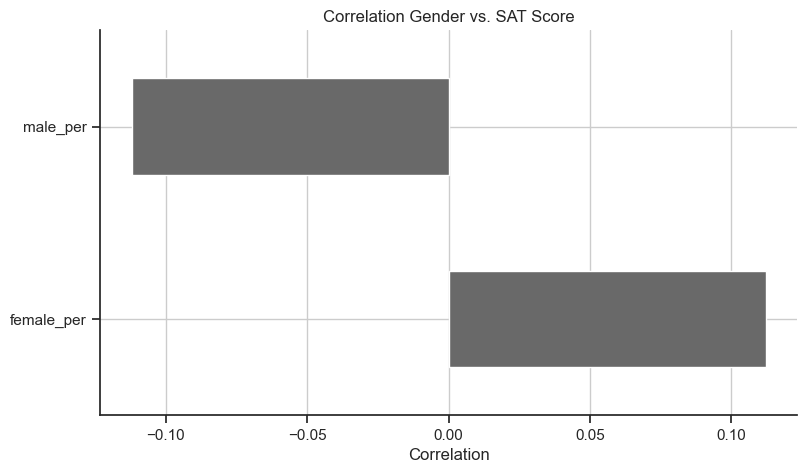

In [33]:
# Create a barplot for correlation values sat_score and gender
plt.figure(figsize=(9,5))
combined.corr(numeric_only=True)['sat_score'][['female_per', 'male_per']].plot(
    kind='barh', grid=True, color='dimgrey')

plt.title('Correlation Gender vs. SAT Score')
plt.xlabel('Correlation')
plt.show()

As you can see above, a high percentage of females at a school positively correlates with `SAT` scores, whereas a high percentage of males negatively correlates with `SAT` scores. The correlations observed do not exhibit a notably high strength.







C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\4202002192.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('cividis')


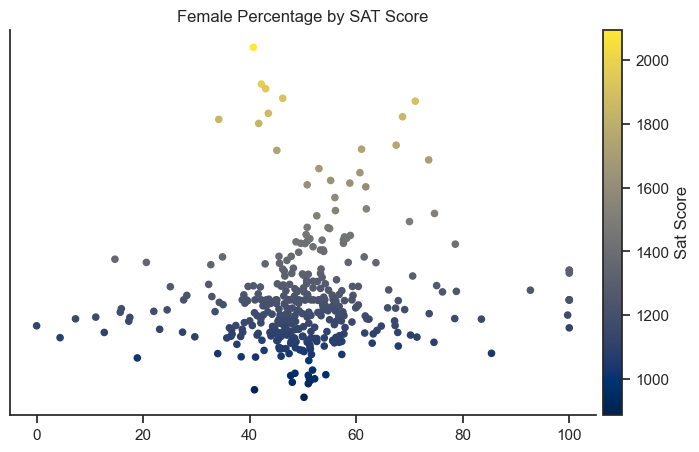

In [34]:
# Create a scatterplot for female percentage score and sat_score

# Create figure and colormap
fig = plt.figure(figsize=(9,5))
cm = plt.cm.get_cmap('cividis')

# Create plot
ax = fig.add_subplot()
colorbar = ax.scatter(combined['female_per'], combined['sat_score'], 
                       c=combined['sat_score'], vmin=combined['sat_score'].min(), 
                       vmax=combined['sat_score'].max(), s=20, cmap=cm)
plt.colorbar(colorbar, label='Sat Score', pad=.01)

# Remove y-axis
ax.yaxis.set_ticks([]) 
plt.title('Female Percentage by SAT Score')
plt.show()

Upon examination of the scatter plot, it doesn't seem to be any real correlation between `sat_score` and `female_per`. Nevertheless, there exists a distinct cluster of schools characterized by a substantial percentage of females (60 to 80) coupled with elevated `SAT` scores.

Let us observe these schools further.






In [35]:
# Filter female_per and sat_score for specific values
combined[(combined['female_per'] > 60) & 
         (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appear to be highly selective liberal arts schools characterized by rigorous academic standards. Additionally, admission to these high schools requires successful completion of an assessment process.








### Advanced Placement Exam

It makes sense that the number of students at a school who took `AP` exams would be highly correlated with the school's `SAT` scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one `AP` exam.

Advanced Placement (`AP`) Exams are standardized assessments intended to evaluate proficiency in the content and skills of a specific AP course. While most AP courses culminate in an end-of-year exam, certain courses employ alternative methods of assessing student learning, such as the submission of portfolios for scoring by AP Art and Design students.





C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\1142352329.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\1142352329.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('cividis')


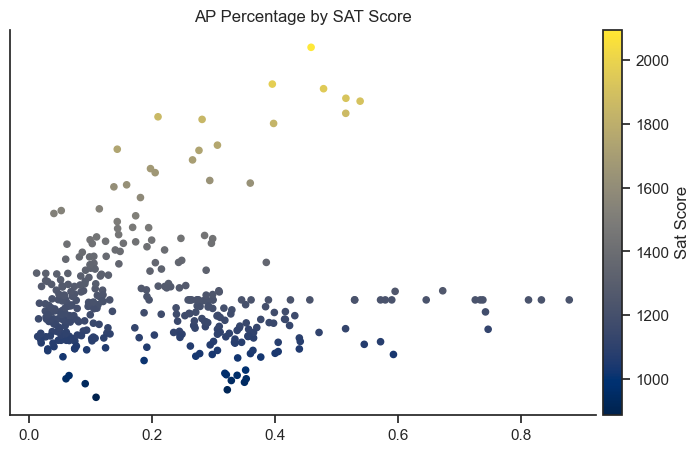

In [36]:
# Create new column AP percentage
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

# Create a scatterplot for AP percentage and sat_score

# Create figure and colormap
fig = plt.figure(figsize=(9,5))
cm = plt.cm.get_cmap('cividis')

# Create plot
ax = fig.add_subplot()
colorbar = ax.scatter(combined['ap_per'], combined['sat_score'], 
                       c=combined['sat_score'], vmin=combined['sat_score'].min(), 
                       vmax=combined['sat_score'].max(), s=20, cmap=cm)
plt.colorbar(colorbar, label='Sat Score', pad=.01)

# Remove y-axis
ax.yaxis.set_ticks([]) 
plt.title('AP Percentage by SAT Score')
plt.show()

In [37]:
combined.corr(numeric_only=True)['sat_score']['ap_per']

0.05717081390766952

Initially, we computed the proportion of students in each school who participated in an `AP` exam by dividing the count in the `AP` Test Takers column by the `total_enrollment` count. Subsequently, we constructed a scatter plot depicting `SAT` scores against the percentage of students taking`AP` exams (`ap_per`). Despite the lack of a distinct pattern in the scatter plot, we computed the Pearson correlation coefficient (`r`) to quantify the relationship between these variables. The resultant `r` value of 0.05 indicates a weak correlation between `SAT` scores and the percentage of students taking `AP` exams.

Moving forward, we aim to assess the correlation between `class size` and `SAT` scores.

In [38]:
# Calculate correlation between class size and sat score
combined.corr(numeric_only=True)['sat_score']['AVERAGE CLASS SIZE']

0.3810143308095529

C:\Users\mexic\AppData\Local\Temp\ipykernel_56876\3453550730.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('cividis')


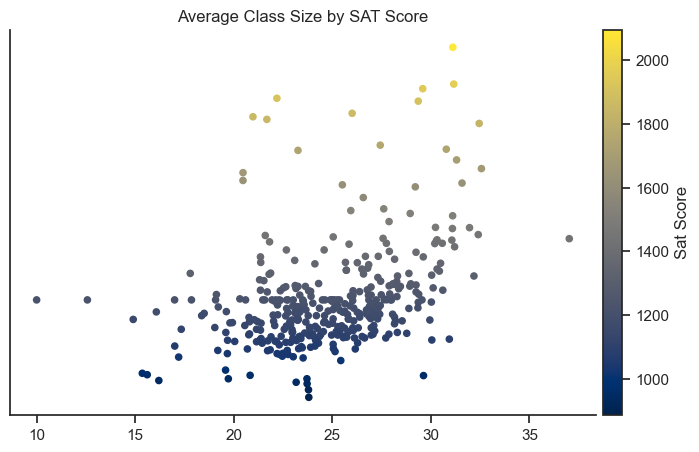

In [39]:
# Create a scatterplot for average class size and sat_score

# Create figure and colormap
fig = plt.figure(figsize=(9,5))
cm = plt.cm.get_cmap('cividis')

# Create plot
ax = fig.add_subplot()
colorbar = ax.scatter(combined['AVERAGE CLASS SIZE'], combined['sat_score'], 
                       c=combined['sat_score'], vmin=combined['sat_score'].min(), 
                       vmax=combined['sat_score'].max(), s=20, cmap=cm)
plt.colorbar(colorbar, label='Sat Score', pad=.01)

# Remove y-axis
ax.yaxis.set_ticks([]) 
plt.title('Average Class Size by SAT Score')
plt.show()

The findings are presented above, revealing an `r` value of 0.38. This implies a low to moderate positive correlation between `SAT` scores and the `average class size`. Specifically, an increase in the `average class size` is associated with an increase in `SAT scores`. The scatter plot illustrates a concentration of values around a `SAT` score of 1200 and an `average class size` of 25, depicting a mild positive trend with larger `class sizes` and heightened `SAT` scores. This outcome is somewhat unexpected, as conventional wisdom often associates smaller classes with improved instructional quality and, consequently, higher `SAT` performance.